# Convergence of Sequences

Pablo Winant

# Tutorial: Convergence

### Solow Model

A representative agent uses capital $k_t$ to produce $y_t$ using the
following production function:

$$y_t = k_t^{\alpha}$$

He chooses to consume an amount $c_t \in ]0, y_t]$ and invests what
remains:

$$i_t = y_t - c_t$$

He accumulates capital $k_t$ according to:

$$k_{t+1} = \left( 1-\delta \right) k_{t} + i_{t}$$

where $\delta$ is the depreciation rate and $i_t$ is the amount
invested.

The goal of the representative agent is to maximize:

$$\sum_{t\geq 0} \beta^t U(c_t)$$

where $U(x)=\frac{x^{1-\gamma}}{1-\gamma}$ and $\beta<1$ is the discount
factor.

For now, we ignore the objective and assume that the saving rate
$s=\frac{c_t}{y_t}$ is constant over time. (1-s plutôt ?)

**Create a `NamedTuple` to hold parameter values $\beta=0.96$,
$\delta=0.1$, $\alpha=0.3$, $\gamma=4$.**

**Write down the formula of function $f$ such that $k_{t+1}$:
$k_{t+1} = f(k_t)$.**

**Define a function `f(k::Float64, p::NamedTuple)::Float64` to represent
$f$ for a given calibration**

In [280]:
# Julia REPL
# ] for packages
# ; for shell

In [282]:
using Plots, Printf
model = (α=0.3, β=0.96, δ=0.1, γ=4)

#? Notes : 
# model_2 = merge(model, (;α=0.4)) to create new model
# syntax to "unpack" values from named tuple : 
# (;α, β, δ, γ) = model

(α = 0.3, β = 0.96, δ = 0.1, γ = 4)

$ f(k_t) :: k_{t+1} = (1-\delta)k_t + s.k_{t}^{\alpha} \qquad $  (S= (1-s) de l'énoncé...)

$ f'(k) = (1-\delta) + s.α.k^{\alpha-1}$

In [290]:
function f(k::Float64, model; s=0.3)

    (;α, β, δ, γ) = model
    y = k^α
    i = s*y
    K = (1-δ)*k + i

    return K
end

function df(k, model; s=0.3)

    (;α, β, δ, γ) = model
    return (1-δ) + s*α*k^(α-1)
end


#* Pour visu méthode de Newton :
# f(k) - k
f1 = (k, model; s=0.3) -> f(k,model; s=s) - k
# f'(k) - 1
f2 = (k, model; s=0.3) -> df(k,model; s=s) - 1
# f(k) - k / f'(k) - 1
f3 = (k, model; s=0.3) -> f1(k,model; s=s) / f2(k,model;s=s)

function plotf(func, model, s; maxy=false)
    grid = LinRange(0,10,1000)
    res = [func(x,model;s=s) for x in grid]
    if maxy
        plt = plot(xlim=(grid[1],grid[end]),ylim=(-50,50))
    else
        plt = plot(xlim=(grid[1],grid[end]),ylim=(minimum(res)*(1-0.1),maximum(res)*(1+0.1)))
    end
    plot!(plt, grid, res, c=:black, label="f")
    plot!(plt,[grid[1],grid[end]], [0,0], c=:gray, label="0")
end

plotf (generic function with 1 method)

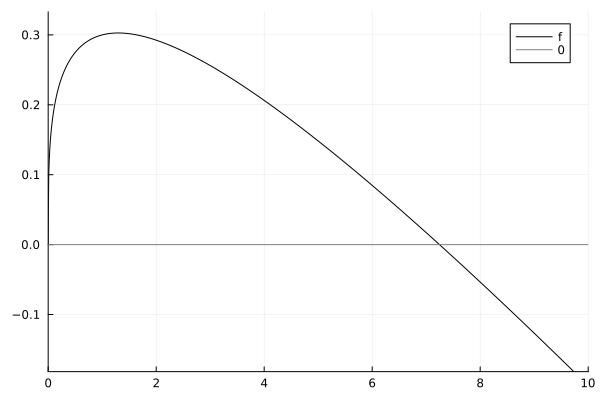

In [286]:
# Plot de f(k) - k
plotf(f1,model,0.4)

**Write a function
`simulate(k0::Float64, T::Int, p::NamedTuple)::Vector{Float64}` to
compute the simulation over `T` periods starting from initial capital
level `k0`.**

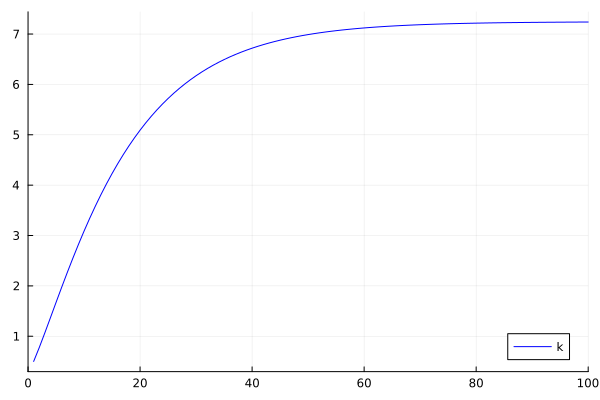

In [287]:
function simulate(k0, model; s=0.4, T=100)
    res = [k0]
    for t=1:T
        k = res[end]
        K = f(k, model; s=s)
        push!(res, K)
    end
    return res
end

fig = plot(xlim=(0,100), legend=:bottomright)
plot!(fig, simulate(0.5, model; T=100), c=:blue, label="k")

#* A l'air de converger vers environ k* = 7.2 

>Make a nice plot to illustrate the convergence. Do we get convergence
from any initial level of capital?

>Suppose you were interested in using `f` to compute the steady-state.
What would you propose to measure convergence speed? To speed-up
convergence? Implement these ideas.

**Problem**
$$ f(x) = x \Leftrightarrow f(x) - x = 0 $$

**Speed up the convergence using Newton's method applied to $\Phi(x) = f(x) - x$**

$$ \textrm{\textbf{Newton}}: \quad k_{n+1} = k_{n} - \frac{f(k_n) - k_n}{f'(k_n)-1}$$

$$ \textrm{\textbf{Success criterion}}: \quad \epsilon_{n} = | f(k_n) |$$
$$ \textrm{\textbf{Convergence speed}}: \quad \eta_{n} = | k_{n+1} - k_{n} | \quad \textrm{\textit{'Successive erros'}}$$
$$ \textrm{\textbf{Ratio of successive errors for kind of convergence}}: \quad \lambda_{n} = \frac{\eta_n}{\eta_{n-1}} \Rightarrow |\lambda_n| < 1 ?$$

In [271]:
for t in 1:10
    print(t)
    if t>2
        break
    end
end

123

In [277]:
# ===== NEWTON =====
function simulate_newton(k0::Float64, model; s=0.4, T=100, deb=false)
    """
    deb : print successive results
    """
    res = [k0]
    succ_errors = []
    
    # Print results also
    for t=1:T
        k = res[end]
        fk = f(k, model; s=s)
        dfk = df(k, model; s=s)

        if dfk!=1
            KN = k - (fk-k)/(dfk-1)
            push!(res,KN)
        else
            break
        end

        crit = abs(fk)
        cvspeed = abs(KN-k)
        push!(succ_errors,cvspeed)

        if (t>1) & deb
            ratio = succ_errors[end]/succ_errors[end-1]
            @printf "iter : %3.0f | Success criterion : %9.6f | Convergence speed : %.6f | Ratio : %f \n" t crit cvspeed ratio
        end
    end
    return res
end

simulate_newton (generic function with 2 methods)

In [278]:
simulate_newton(2.0, model,deb=true)

iter :   2 | Success criterion : 12.739922 | Convergence speed : 5.629485 | Ratio : 0.502999 
iter :   3 | Success criterion :  7.540055 | Convergence speed : 0.314616 | Ratio : 0.055887 
iter :   4 | Success criterion :  7.247604 | Convergence speed : 0.001952 | Ratio : 0.006203 
iter :   5 | Success criterion :  7.245789 | Convergence speed : 0.000000 | Ratio : 0.000040 
iter :   6 | Success criterion :  7.245789 | Convergence speed : 0.000000 | Ratio : 0.000000 
iter :   7 | Success criterion :  7.245789 | Convergence speed : 0.000000 | Ratio : NaN 
iter :   8 | Success criterion :  7.245789 | Convergence speed : 0.000000 | Ratio : NaN 
iter :   9 | Success criterion :  7.245789 | Convergence speed : 0.000000 | Ratio : NaN 
iter :  10 | Success criterion :  7.245789 | Convergence speed : 0.000000 | Ratio : NaN 
iter :  11 | Success criterion :  7.245789 | Convergence speed : 0.000000 | Ratio : NaN 
iter :  12 | Success criterion :  7.245789 | Convergence speed : 0.000000 | Ratio : N

101-element Vector{Float64}:
  2.0
 13.191841637917717
  7.562356859602338
  7.247740898887396
  7.245789392926962
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  ⋮
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253
  7.245789314111253

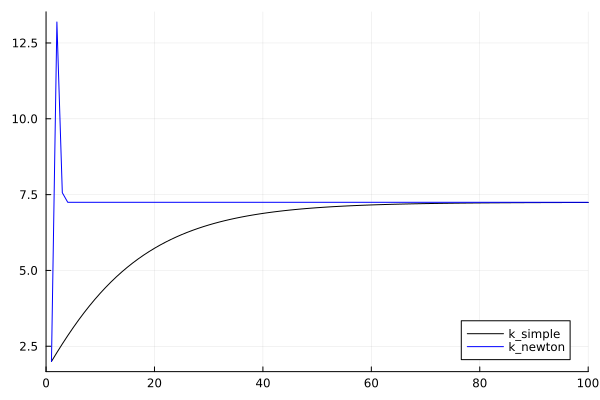

In [279]:
fig = plot(xlim=(0,100), legend=:bottomright)
plot!(fig, simulate(2.0, model; T=100), c=:black, label="k_simple")
plot!(fig, simulate_newton(2.0, model; T=100), c=:blue, label="k_newton")

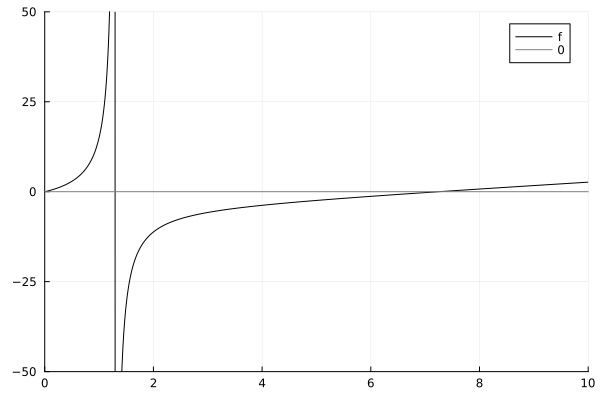

In [291]:
# Il y a un problème avec méthode de Newton si on initialise k0 < environ 1.4
plotf(f3,model,0.4,maxy=true)